In [1]:
!pip install mpi4py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
%%writefile bifurcation.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np

def parallel_bifurcation(proc, points_X = 1000, n_proc = 8, minX = 0, maxX = 4, steps = 10000, m = 30):
    block_X = points_X // n_proc # integer blocks of x axis
    remainder = points_X % n_proc # remainder for the last block

    add = 0 # addition of the last block
    if proc == n_proc - 1: # if current process is last
        add = remainder # addition is equal to remainder
    
    # current x array
    arrayX = np.arange(block_X * proc, block_X * (proc + 1) + add, 1)
    
    r = np.linspace((proc) * maxX / n_proc, (proc + 1) * maxX / n_proc, arrayX.size)
    
    X = np.zeros((block_X, m)) # array for scatterplot
    Y = np.zeros((block_X, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in range(0, block_X, 1):
        x[0] = np.random.rand()
        
        for n in range(1, steps):
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            
        X[j] = (x[steps - m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot
    return X, Y

comm = MPI.COMM_WORLD
n_proc = comm.Get_size() # processors
rank = comm.Get_rank() # current rank

if rank == 0:
    t0 = MPI.Wtime() # measure start time

X, Y = parallel_bifurcation(proc = rank, points_X = 2000, n_proc = n_proc, minX = 0, maxX = 4, steps = 500, m = 40)
X, Y = comm.gather(X, root=0), comm.gather(Y, root=0)

if rank == 0:
    t = MPI.Wtime() - t0
    with open('./time.csv', 'a+') as f:
         f.write(f'{n_proc}, {np.round(t, 4) * 1000}\n')

    fig = plt.scatter(Y, X, c = 'b', s = 0.05)

    plt.title('Bifurcation diagram', fontsize=12)
    plt.ylabel('Values of static points', fontsize=12)
    plt.xlabel('Value of r', fontsize=12)
    plt.savefig(f'./bifurcation_{n_proc}_processes', dpi=300)
    plt.close()

Overwriting bifurcation.py


In [3]:
%%bash
for k in {1..8}
do
    for i in {1..12}
    do
      mpirun --oversubscribe -n $i python3 bifurcation.py   
    done
done

--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MacBook-Pro-Maxim-2.local
  System call: unlink(2) /var/folders/vq/7_r55y9s2234cm1m8xwqth5m0000gn/T//ompi.MacBook-Pro-Maxim-2.501/pid.52606/1/vader_segment.MacBook-Pro-Maxim-2.501.8f330001.2
  Error:       No such file or directory (errno 2)
--------------------------------------------------------------------------
--------------------------------------------------------------------------
A system call failed during shared memory initialization that should
not have.  It is likely that your MPI job will now either abort or
experience performance degradation.

  Local host:  MacBook-Pro-Maxim-2.local
  System call: unlink(2) /var/folders/vq/7_r55y9s2234cm1m8xwqth5m0000gn/T//ompi.MacBook-Pro-Maxim-2.501/pid.52715/1/vader_segment.M

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
import pandas as pd

In [5]:
time = pd.read_csv("./time.csv", header=None, names=["n_proc", "time"])
time.head()

,n_proc,time
0,1,976.1
1,2,485.9
2,3,324.7
3,4,259.4
4,5,284.7


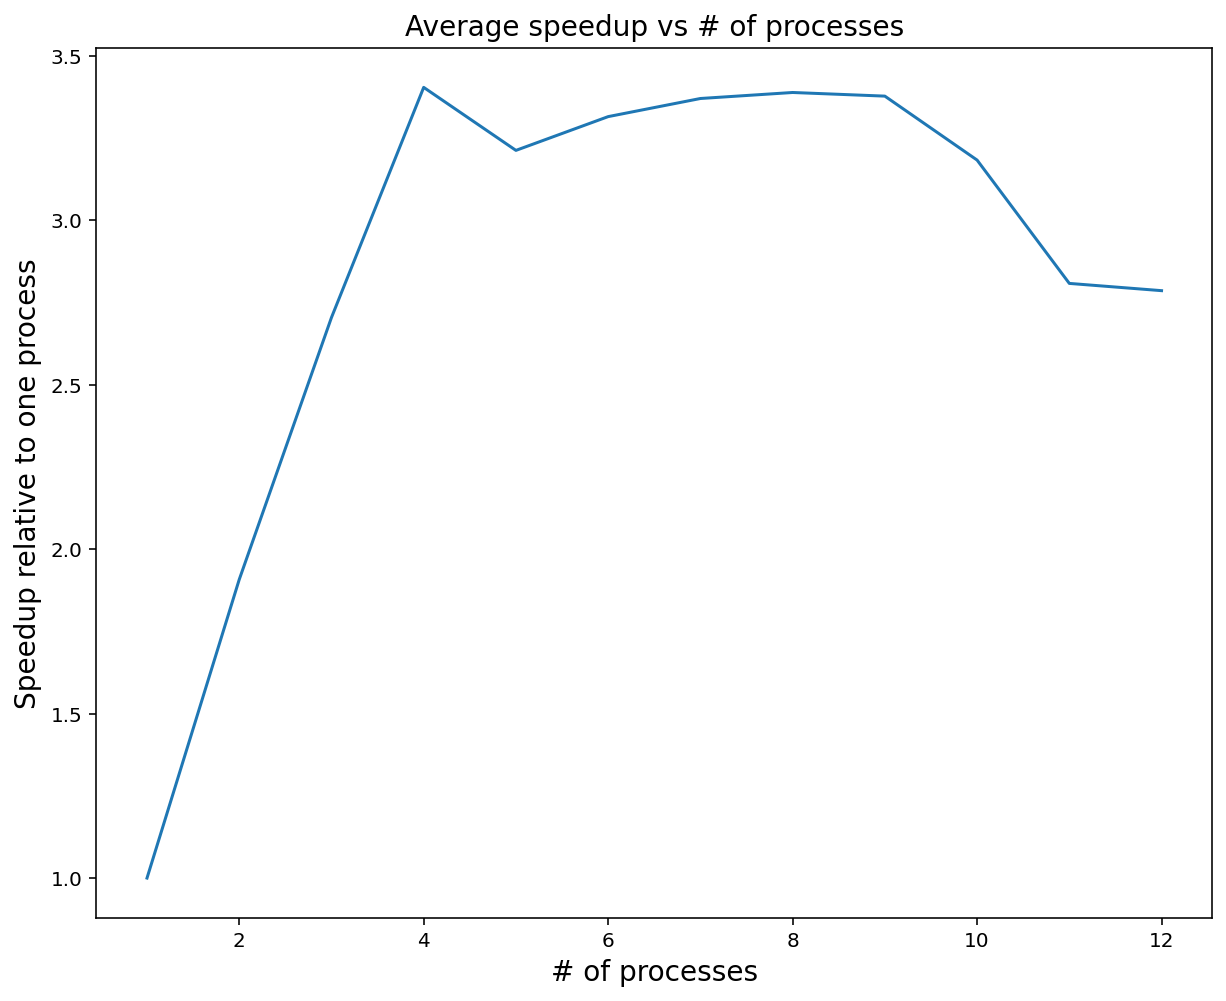

In [6]:
times = time.groupby("n_proc")['time'].mean()
plt.figure(figsize=(10,8))
plt.plot(times[1] / times)
plt.title('Average speedup vs # of processes', fontsize=14)
plt.ylabel('Speedup relative to one process', fontsize=14)
plt.xlabel('# of processes', fontsize=14)
plt.show()

On average, paralellization of our algorithm indeed provides speedup almost linear by # of processes, although, too much processess create a too big overhead and don't improve excecution time.